## Loading libaries and path

In [2]:
import os
import requests
from tqdm import tqdm
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
import cv2
import geopandas as gpd
from shapely.geometry import box
import pandas as pd


# Define the URLs provided in the image
granule = "40S_080W"

output_dir = "./data/chile_gfc_data"
os.makedirs(output_dir, exist_ok=True)

datamask_path = f"/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/data/chile_gfc_data/Hansen_GFC-2024-v1.12_datamask_{granule}.tif"
treecover2000_path = f"/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/data/chile_gfc_data/Hansen_GFC-2024-v1.12_treecover2000_{granule}.tif"
lossyear_path = f"/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/data/chile_gfc_data/Hansen_GFC-2024-v1.12_lossyear_{granule}.tif"   
gain_path = f"/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/data/chile_gfc_data/Hansen_GFC-2024-v1.12_gain_{granule}.tif"  

## Creating the mask 

In [35]:

# We will read only 1 out of every 10 pixels (decimation).
# This reduces data size from 1.6GB to ~16MB per band.
decimation_factor = 10 
# --- CONFIGURATION ---
DENSITY_THRESHOLD = 0.005  # Adjust based on your visual preference from Insight B
BLOCK_SIZE = 2048          # Process 2048x2048 pixels at a time
RECENCY_THRESHOLD_YEAR = 5

mask_output_path = os.path.join(output_dir, f"{granule}_filtered_segmentation_mask_hard_{str(DENSITY_THRESHOLD).replace(".","")}_{RECENCY_THRESHOLD_YEAR}.tif")
print("Loading data with smart decimation to prevent RAM crash...")

with rasterio.open(lossyear_path) as src:
    # Calculate new shape
    new_height = src.height // decimation_factor
    new_width = src.width // decimation_factor
    
    # Read with resampling (nearest neighbor is fine for discrete classes)
    lossyear_small = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=rasterio.enums.Resampling.nearest
    )

with rasterio.open(treecover2000_path) as src:
    tc2000_small = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=rasterio.enums.Resampling.nearest
    )

with rasterio.open(datamask_path) as src:
    datamask_small = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=rasterio.enums.Resampling.nearest
    )

print(f"Data successfully loaded. New shape: {lossyear_small.shape}")


# 1. Create Masks
land_mask_small = (datamask_small == 1)
forest_baseline_mask_small = (tc2000_small > 30)

# 2. Create Cumulative Loss Layer
# Apply masks: Must be land, must have been forest, must have loss > 0
cumulative_loss_small = (
    (lossyear_small >= RECENCY_THRESHOLD_YEAR) & 
    forest_baseline_mask_small & 
    land_mask_small
).astype(np.float32) # float32 is safe now because the array is small

# 3. Apply Gaussian Density with adjusted Sigma
# Since we downsampled by 10x, we reduce sigma by 10x to keep the same physical radius.
# Old sigma=50 (approx 1.5km) -> New sigma=5.
sigma_adjusted = 5 
loss_density_heatmap = gaussian_filter(cumulative_loss_small, sigma=sigma_adjusted)

# --- STEP 1: PREPARE THE HOTSPOT MASK (Full Size) ---
# We still need one full-size reference mask. Since it's uint8, it takes ~1.6GB RAM.
# This usually fits, provided we don't load the other files simultaneously.

print("1. Preparing Hotspot Mask...")
# Re-create the small mask from your previous steps (assuming variables exist)
# If variables were lost in crash, re-run the 'Insight B' code first!
hotspot_mask_small = (loss_density_heatmap > DENSITY_THRESHOLD).astype(np.uint8)

# Get dimensions from a reference file
with rasterio.open(lossyear_path) as src:
    H, W = src.height, src.width
    profile = src.profile.copy()

# Resize to full resolution
# This is the only large object we keep in RAM
hotspot_mask_full = cv2.resize(
    hotspot_mask_small, 
    (W, H), 
    interpolation=cv2.INTER_NEAREST
)
print(f"   Hotspot mask ready: {hotspot_mask_full.shape}")

# --- STEP 2: CONFIGURE OUTPUT PROFILE ---
profile.update({
    'dtype': rasterio.uint8,
    'count': 1,
    'nodata': 0,
    'driver': 'GTiff',
    'compress': 'lzw',
    'tiled': True,        # tiling improves read speed for future usage
    'blockxsize': 256,
    'blockysize': 256
})

# --- STEP 3: BLOCK PROCESSING LOOP ---
print("2. Starting Block Processing (Memory Safe Mode)...")

# Open all input files in 'r' mode (lazy loading)
with rasterio.open(lossyear_path) as src_ly, \
     rasterio.open(gain_path) as src_gain, \
     rasterio.open(treecover2000_path) as src_tc, \
     rasterio.open(datamask_path) as src_dm, \
     rasterio.open(mask_output_path, 'w', **profile) as dst:
    
    # Create a window iterator
    # We use the output file 'dst' to define the windows
    windows = [window for ji, window in dst.block_windows(1)]
    
    # Iterate with a progress bar
    for window in tqdm(windows):
        # A. Read only the data for this specific window
        loss_chunk = src_ly.read(1, window=window)
        gain_chunk = src_gain.read(1, window=window)
        tc_chunk = src_tc.read(1, window=window)
        dm_chunk = src_dm.read(1, window=window)
        
        # B. Slice the corresponding part of our Hotspot Mask
        # window.row_off / col_off tells us where we are in the big image
        r_start = window.row_off
        r_end = r_start + window.height
        c_start = window.col_off
        c_end = c_start + window.width
        
        hotspot_chunk = hotspot_mask_full[r_start:r_end, c_start:c_end]
        
        # C. Compute the Logic (Small arrays = Low RAM usage)
        mask_chunk = (
            (loss_chunk >= RECENCY_THRESHOLD_YEAR) & 
            #(loss_chunk > 0) & 
            #(gain_chunk == 0) &  ## GAIN ARE ONLY UNTIL 2012
            (tc_chunk > 30) & 
            (dm_chunk == 1) & 
            (hotspot_chunk == 1)
        ).astype(np.uint8)
        
        # D. Write the result immediately to disk
        dst.write(mask_chunk, 1, window=window)

print(f"Success! Mask saved to: {mask_output_path}")

Loading data with smart decimation to prevent RAM crash...
Data successfully loaded. New shape: (4000, 4000)
1. Preparing Hotspot Mask...
   Hotspot mask ready: (40000, 40000)
2. Starting Block Processing (Memory Safe Mode)...


100%|██████████| 24649/24649 [00:18<00:00, 1328.04it/s]

Success! Mask saved to: ./data/chile_gfc_data/30S_080W_filtered_segmentation_mask_hard_0005_5.tif


26622


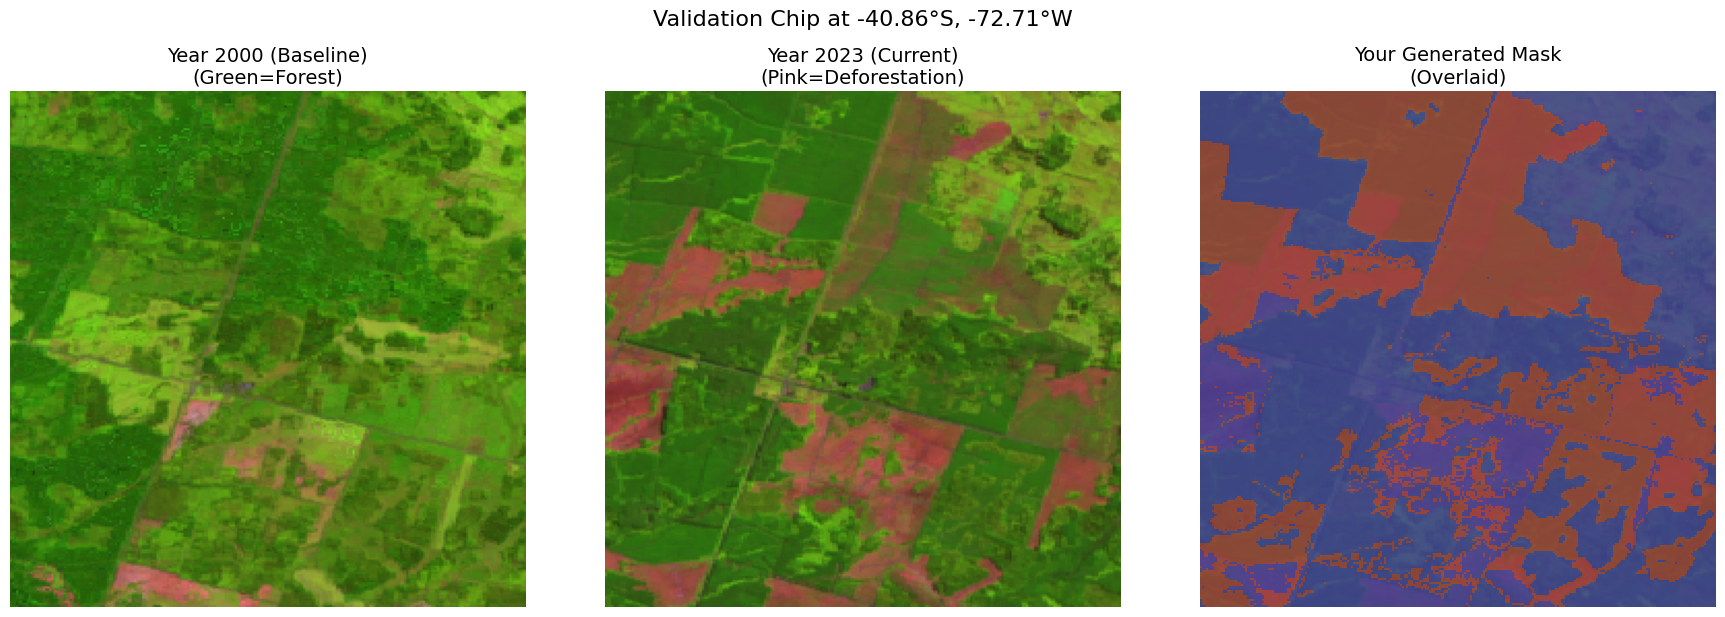

In [3]:

DENSITY_THRESHOLD = 0.005  # Adjust based on your visual preference from Insight B
RECENCY_THRESHOLD_YEAR = 17

mask_path = os.path.join(output_dir, f"{granule}_filtered_segmentation_mask_hard_{str(DENSITY_THRESHOLD).replace(".","")}_{RECENCY_THRESHOLD_YEAR}.tif")
first_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_first_{granule}.tif")
last_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_last_{granule}.tif")


def normalize(array):
    """Normalize bands to 0-1 for plotting"""
    array_min, array_max = 0, 150 # Landsat pixel values usually 0-255 or larger. 
    # Hansen data is often 8-bit or scaled. 
    # Adjusting max to 150 brightens the image.
    return np.clip((array - array_min) / (array_max - array_min), 0, 1)

def plot_validation_chip(center_lat, center_lon, mask_output_path, zoom_pixels=250):
    """
    Extracts a small chip from all datasets to validate visually.
    center_lat, center_lon: Geographic coordinates of the spot to check.
    zoom_pixels: Size of the window (e.g., 200x200 pixels).
    """
    
    # 1. Convert Lat/Lon to Pixel Coordinates
    with rasterio.open(lossyear_path) as src:
        # simply py, px = src.index(lon, lat) but rasterio uses (x,y) = (lon,lat)
        py, px = src.index(center_lon, center_lat)
        window = rasterio.windows.Window(px - zoom_pixels//2, py - zoom_pixels//2, zoom_pixels, zoom_pixels)
    
    # 2. Read the "Before" (Year 2000) Chip
    with rasterio.open(first_path) as src:
        # Bands: 1=Red, 2=NIR, 3=SWIR1, 4=SWIR2
        # We want SWIR, NIR, Red for the composite (R, G, B channels)
        b_swir = src.read(3, window=window)
        b_nir  = src.read(2, window=window)
        b_red  = src.read(1, window=window)
        img_2000 = np.dstack((normalize(b_swir), normalize(b_nir), normalize(b_red)))

    # 3. Read the "After" (Year 2023) Chip
    with rasterio.open(last_path) as src:
        b_swir = src.read(3, window=window)
        b_nir  = src.read(2, window=window)
        b_red  = src.read(1, window=window)
        img_2023 = np.dstack((normalize(b_swir), normalize(b_nir), normalize(b_red)))

    # 4. Read Your Mask Chip
    with rasterio.open(mask_output_path) as src:
        mask_chip = src.read(1, window=window)

    print((mask_chip>0).sum())
    # 5. Plot Comparison
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Year 2000
    ax[0].imshow(img_2000)
    ax[0].set_title("Year 2000 (Baseline)\n(Green=Forest)", fontsize=14)
    ax[0].axis('off')
    
    # Year 2023
    ax[1].imshow(img_2023)
    ax[1].set_title("Year 2023 (Current)\n(Pink=Deforestation)", fontsize=14)
    ax[1].axis('off')
    
    # Your Mask
    # Overlay mask on top of 2023 image for clarity
    ax[2].imshow(img_2023, alpha=0.5) 
    ax[2].imshow(mask_chip, cmap='jet', alpha=0.6, interpolation='nearest') 
    ax[2].set_title("Your Generated Mask\n(Overlaid)", fontsize=14)
    ax[2].axis('off')
    
    plt.suptitle(f"Validation Chip at {center_lat}°S, {center_lon}°W", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# --- RUN VALIDATION ---
# Pick a coordinate known to have high deforestation (from your previous heatmap!)
# This is a random spot near Osorno/Coastal Range often hit by forestry
# You can change these coordinates to explore your map!
#-40.549459, -72.129868#
lat_target = -40.86#-40.86 #-41.3#-40.6
#-40.6#-40.85
lon_target = -72.71#-72.71#-72.6#-72
##-72#-73.65

#Lat -47.3701, Lon -72.8849

try:
    plot_validation_chip(lat_target, lon_target, mask_path)
except Exception as e:
    print(f"Error: {e}")
    print("Ensure you downloaded the 'first' and 'last' files and the coordinates are inside the granule!")

In [20]:

DENSITY_THRESHOLD = 0.005  # Adjust based on your visual preference from Insight B
RECENCY_THRESHOLD_YEAR = 20

mask_path = os.path.join(output_dir, f"{granule}_filtered_segmentation_mask_hard_{str(DENSITY_THRESHOLD).replace(".","")}_{RECENCY_THRESHOLD_YEAR}.tif")
first_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_first_{granule}.tif")
last_path = os.path.join(output_dir, f"Hansen_GFC-2024-v1.12_last_{granule}.tif")


def search_zoi(center_lat, center_lon, mask_output_path, zoom_pixels=250):

    with rasterio.open(lossyear_path) as src:
        # simply py, px = src.index(lon, lat) but rasterio uses (x,y) = (lon,lat)
        py, px = src.index(center_lon, center_lat)
        window = rasterio.windows.Window(px - zoom_pixels//2, py - zoom_pixels//2, zoom_pixels, zoom_pixels)

    with rasterio.open(mask_output_path) as src:
        mask_chip = src.read(1, window=window)

    return mask_chip.sum()

# --- RUN SEARCH FOR ZOI ---
# Pick a coordinate known to have high deforestation (from your previous heatmap!)
# This is a random spot near Osorno/Coastal Range often hit by forestry
# You can change these coordinates to explore your map!
#-40.549459, -72.129868#
lat_target = -40.86 #-41.3#-40.6
#-40.6#-40.85
lon_target = -72.71#-72.6#-72
##-72#-73.65

try:
    zoi_count = search_zoi(lat_target, lon_target, mask_path)
    print(f"Zone of Interest (ZOI) Pixel Count at {lat_target}°S, {lon_target}°W: {zoi_count} pixels")
except Exception as e:
    print(f"Error: {e}")
    print("Ensure you downloaded the 'first' and 'last' files and the coordinates are inside the granule!")

Zone of Interest (ZOI) Pixel Count at -40.86°S, -72.71°W: 16379 pixels


In [21]:
import rasterio
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter
from skimage.feature import peak_local_max

def find_sparse_zois(mask_path, chip_size=512, num_locations=10, min_distance_pixels=512):
    """
    Scans the entire mask to find the top 'num_locations' with the most deforestation.
    Enforces 'min_distance_pixels' between them to ensure variety.
    """
    print(f"Scanning {mask_path} for top {num_locations} hotspots...")
    
    # 1. Load Data (Downsampled for speed)
    # We read at 1/10th resolution. This is enough to find "hot regions".
    decimation = 10
    
    with rasterio.open(mask_path) as src:
        # Read low-res overview
        H, W = src.height, src.width
        # Use 'out_shape' to read a thumbnail version efficiently
        mask_small = src.read(
            1, 
            out_shape=(H // decimation, W // decimation),
            resampling=rasterio.enums.Resampling.bilinear
        )
        transform = src.transform
        crs = src.crs

    print(f"   Analysis Grid: {mask_small.shape}")

    # 2. Generate Density Score Map
    # We want to know: "If I place a chip here, how many '1's are inside?"
    # A uniform filter computes the local mean. 
    # Scaled chip size: If chip is 512px, in 1/10th scale it's ~51px.
    scaled_size = int(chip_size / decimation)
    
    # This creates a "heatmap" where bright pixels = dense deforestation zones
    score_map = uniform_filter(mask_small.astype(float), size=scaled_size)

    # 3. Find Sparse Peaks
    # peak_local_max finds local maxima and ensures they are 'min_distance' apart
    scaled_dist = int(min_distance_pixels / decimation)
    
    coordinates = peak_local_max(
        score_map, 
        min_distance=scaled_dist, 
        threshold_abs=0.01, # Ignore areas with almost 0 deforestation
        num_peaks=num_locations
    )

    # 4. Convert back to Real World Coordinates (Lat/Lon)
    results = []
    
    print(f"\n--- Top {len(coordinates)} Zones Found ---")
    for i, (py_small, px_small) in enumerate(coordinates):
        # Convert small pixel -> large pixel
        px_large = px_small * decimation
        py_large = py_small * decimation
        
        # Get Lat/Lon using the original file transform
        lon, lat = rasterio.transform.xy(transform, py_large, px_large, offset='center')
        
        # Get the relative "score" (density)
        score = score_map[py_small, px_small]
        
        results.append({
            "rank": i+1,
            "lat": lat,
            "lon": lon,
            "density_score": score
        })
        print(f"   Rank {i+1}: Lat {lat:.4f}, Lon {lon:.4f} (Score: {score:.4f})")

    return pd.DataFrame(results)

# --- USAGE ---
# mask_file = "path/to/your/filtered_mask.tif"

# # Find 10 zones, ensuring they are at least 1000 pixels apart (approx 10km)
df_zoi = find_sparse_zois(mask_path, chip_size=512, num_locations=10, min_distance_pixels=1000)

print(df_zoi)
# # Iterate and Download
#output_folder = "./data/chile_gfc_data/generated_chips"

# for idx, row in df_zoi.iterrows():
#     print(f"\nProcessing ZOI #{row['rank']}...")
#     try:
#         get_aligned_chips(row['lat'], row['lon'], "2023-01-01/2023-12-31", mask_path, output_folder)
#     except Exception as e:
#         print(f"Skipping: {e}")

Scanning ./data/chile_gfc_data/40S_080W_filtered_segmentation_mask_hard_0005_20.tif for top 10 hotspots...
   Analysis Grid: (4000, 4000)

--- Top 10 Zones Found ---
   Rank 1: Lat -47.3701, Lon -72.8849 (Score: 0.6448)
   Rank 2: Lat -40.8451, Lon -73.4449 (Score: 0.5782)
   Rank 3: Lat -42.0351, Lon -71.4049 (Score: 0.5398)
   Rank 4: Lat -41.4176, Lon -72.8249 (Score: 0.5317)
   Rank 5: Lat -42.8451, Lon -71.5524 (Score: 0.5121)
   Rank 6: Lat -41.3726, Lon -73.7524 (Score: 0.4979)
   Rank 7: Lat -41.4926, Lon -71.6649 (Score: 0.4606)
   Rank 8: Lat -42.2951, Lon -73.6399 (Score: 0.4560)
   Rank 9: Lat -40.8976, Lon -72.6899 (Score: 0.4460)
   Rank 10: Lat -40.4926, Lon -72.5074 (Score: 0.3441)
   rank        lat        lon  density_score
0     1 -47.370125 -72.884875       0.644752
1     2 -40.845125 -73.444875       0.578239
2     3 -42.035125 -71.404875       0.539792
3     4 -41.417625 -72.824875       0.531719
4     5 -42.845125 -71.552375       0.512111
5     6 -41.372625 -73.

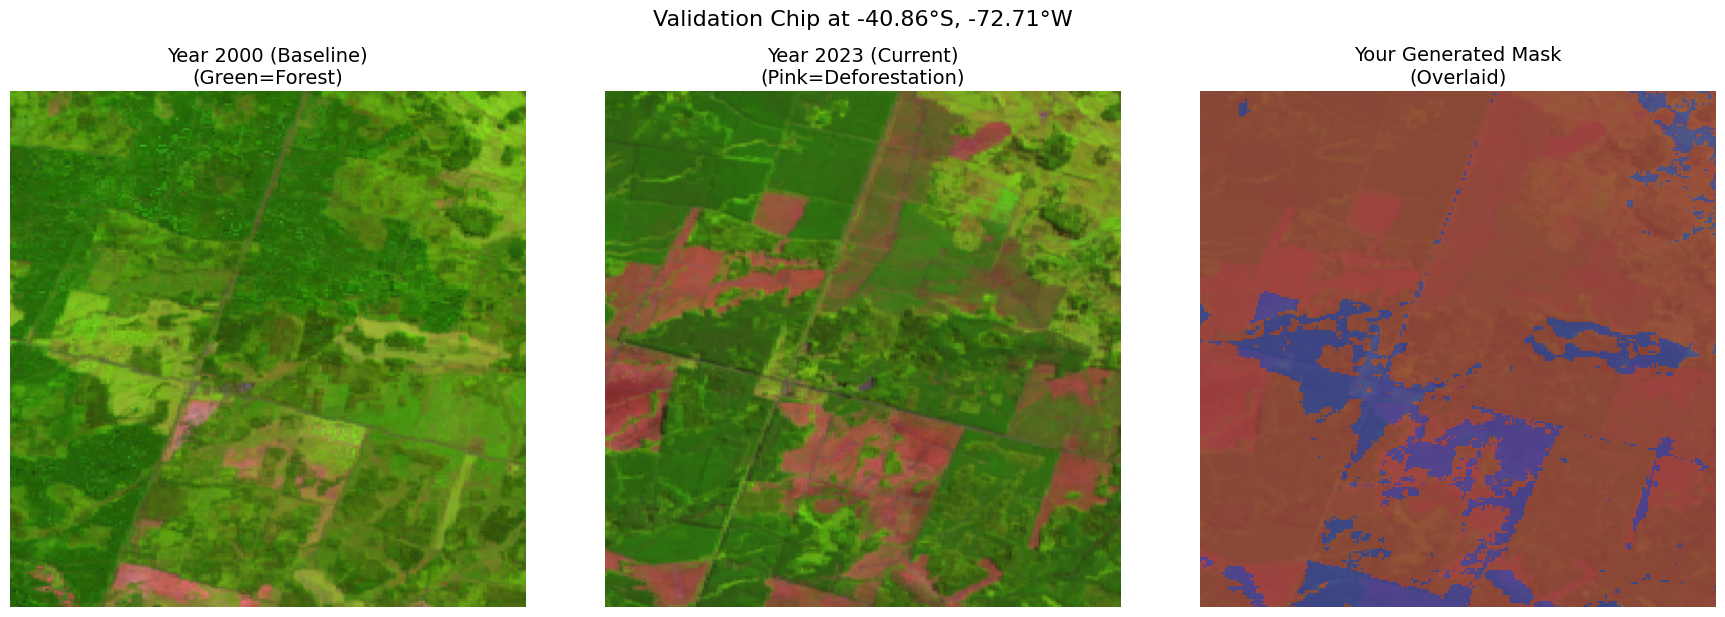

In [17]:

DENSITY_THRESHOLD = 0.05  # Adjust based on your visual preference from Insight B
RECENCY_THRESHOLD_YEAR = 0

mask_path = os.path.join(output_dir, f"{granule}_filtered_segmentation_mask_hard_{str(DENSITY_THRESHOLD).replace(".","")}_{RECENCY_THRESHOLD_YEAR}.tif")
try:
    plot_validation_chip(lat_target, lon_target, mask_path)
except Exception as e:
    print(f"Error: {e}")
    print("Ensure you downloaded the 'first' and 'last' files and the coordinates are inside the granule!")

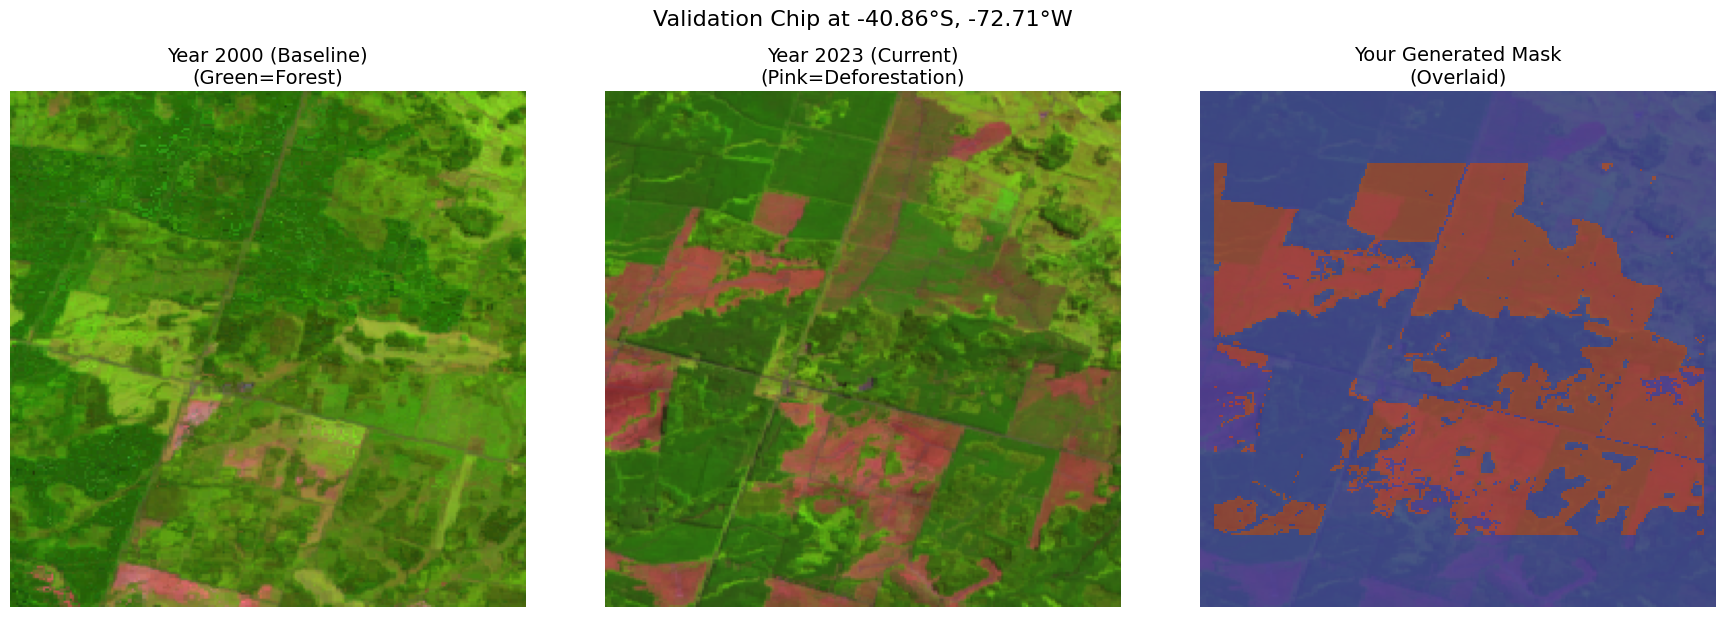

In [22]:

DENSITY_THRESHOLD = 0.005  # Adjust based on your visual preference from Insight B
RECENCY_THRESHOLD_YEAR = 0

mask_path = os.path.join(output_dir, f"{granule}_filtered_S2_calculated_{str(DENSITY_THRESHOLD).replace(".","")}.tif")
try:
    plot_validation_chip(lat_target, lon_target, mask_path)
except Exception as e:
    print(f"Error: {e}")
    print("Ensure you downloaded the 'first' and 'last' files and the coordinates are inside the granule!")

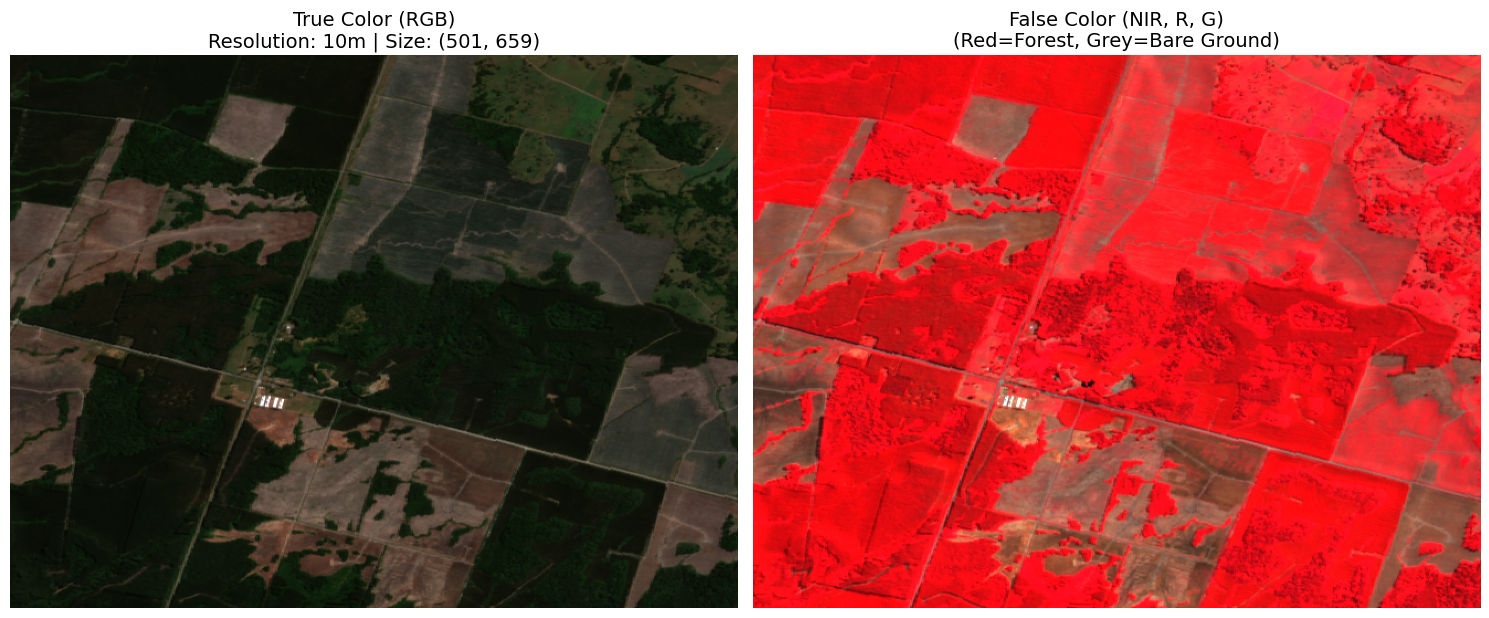

In [10]:

# Define the file path (from your GEE export)
sentinel_path = os.path.join("./data/chile_gfc_data", 'sentinel2_2024_chile_roi2.tif')

if not os.path.exists(sentinel_path):
    print(f"Error: File {sentinel_path} not found. Did the GEE export finish?")
else:
    def normalize(band):
        """Normalize Sentinel-2 (0-10000) to 0-1 range for display."""
        # We clip at 3000 (30% reflectance) to brighten the image
        return np.clip(band / 3000.0, 0, 1)

    with rasterio.open(sentinel_path) as src:
        # Based on your GEE script order: 1=Red, 2=Green, 3=Blue, 4=NIR
        red   = src.read(1)
        green = src.read(2)
        blue  = src.read(3)
        nir   = src.read(4)
        
        # 1. Create True Color Composite (R, G, B)
        rgb = np.dstack((normalize(red), normalize(green), normalize(blue)))
        
        # 2. Create False Color Composite (NIR, Red, Green)
        # In this view: Healthy Forest = Bright Red. Deforestation = Grey/Cyan.
        false_color = np.dstack((normalize(nir), normalize(red), normalize(green)))

        # Plot
        fig, ax = plt.subplots(1, 2, figsize=(15, 8))
        
        ax[0].imshow(rgb)
        ax[0].set_title(f"True Color (RGB)\nResolution: 10m | Size: {red.shape}", fontsize=14)
        ax[0].axis('off')
        
        ax[1].imshow(false_color)
        ax[1].set_title("False Color (NIR, R, G)\n(Red=Forest, Grey=Bare Ground)", fontsize=14)
        ax[1].axis('off')
        
        plt.tight_layout()
        plt.show()

## Creating a filtering with Sentinel where if there is forest it is a false postivce

In [2]:
from rasterio.warp import reproject, Resampling

# --- 5. SPECTRAL CLEANING (The "Pink" Logic) ---
# This step requires your Sentinel-2 Image path
mask_output_path = os.path.join(output_dir, f"{granule}_filtered_segmentation_mask_hard_2.tif")
sentinel_path = sentinel_path = os.path.join("./data/chile_gfc_data", 'sentinel2_2024_chile_roi2.tif')
final_output_path = mask_output_path.replace(".tif", "_spectrally_cleaned.tif")

# 1. Load the Sentinel Image (The "Target" Grid)
with rasterio.open(sentinel_path) as src_s2:
    # Get the metadata we want to match
    s2_profile = src_s2.profile
    s2_transform = src_s2.transform
    s2_crs = src_s2.crs
    s2_shape = src_s2.shape # (Height, Width)
    
    # Read Bands for NDVI (Red=1, NIR=4 in our GEE script)
    red = src_s2.read(1).astype(float)
    nir = src_s2.read(4).astype(float)
    
    # Calculate NDVI (Greenness Index)
    ndvi = (nir - red) / (nir + red + 1e-8)
    
    print(f"Sentinel-2 Shape: {s2_shape} (10m resolution)")

# 2. Extract & Align the Mask (Reprojection)
print("Aligning Hansen Mask to Sentinel Grid (30m -> 10m)...")

# Prepare an empty array to hold the reprojected mask
# It must match the Sentinel shape exactly
aligned_mask = np.zeros(s2_shape, dtype=np.uint8)

with rasterio.open(mask_output_path) as src_mask:
    # The Magic Step: Reproject performs Crop + Resize + Align simultaneously
    reproject(
        source=rasterio.band(src_mask, 1),
        destination=aligned_mask,
        src_transform=src_mask.transform,
        src_crs=src_mask.crs,
        dst_transform=s2_transform,
        dst_crs=s2_crs,
        resampling=Resampling.nearest # Use Nearest for labels (keep them 0 or 1)
    )

# 3. Apply Spectral Cleaning
print("Applying Spectral Cleaning...")
# If Mask says "Loss" (1) BUT NDVI says "Green" (>0.6), set to 0.
initial_pixels = np.sum(aligned_mask)
false_positives = (aligned_mask == 1) & (ndvi > 0.6)
aligned_mask[false_positives] = 0
final_pixels = np.sum(aligned_mask)

print(f"   Original Deforestation Pixels: {initial_pixels}")
print(f"   Removed (Regrowth/False Pos):  {initial_pixels - final_pixels}")
print(f"   Final Label Pixels:            {final_pixels}")

# 4. Save the Result
# We use the Sentinel profile because the output matches Sentinel dimensions
out_profile = s2_profile.copy()
out_profile.update({
    'dtype': rasterio.uint8,
    'count': 1,
    'nodata': 0,
    'driver': 'GTiff'
})

with rasterio.open(final_output_path, 'w', **out_profile) as dst:
    dst.write(aligned_mask, 1)

print(f"SUCCESS! ML-Ready Label saved to: {final_output_path}")
print("You now have a pair of images with identical shapes:")
print(f"   X (Input):  {sentinel_path}")
print(f"   Y (Target): {final_output_path}")

Sentinel-2 Shape: (501, 659) (10m resolution)
Aligning Hansen Mask to Sentinel Grid (30m -> 10m)...
Applying Spectral Cleaning...
   Original Deforestation Pixels: 118895
   Removed (Regrowth/False Pos):  96585
   Final Label Pixels:            22310
SUCCESS! ML-Ready Label saved to: ./data/chile_gfc_data/40S_080W_filtered_segmentation_mask_hard_2_spectrally_cleaned.tif
You now have a pair of images with identical shapes:
   X (Input):  ./data/chile_gfc_data/sentinel2_2024_chile_roi2.tif
   Y (Target): ./data/chile_gfc_data/40S_080W_filtered_segmentation_mask_hard_2_spectrally_cleaned.tif


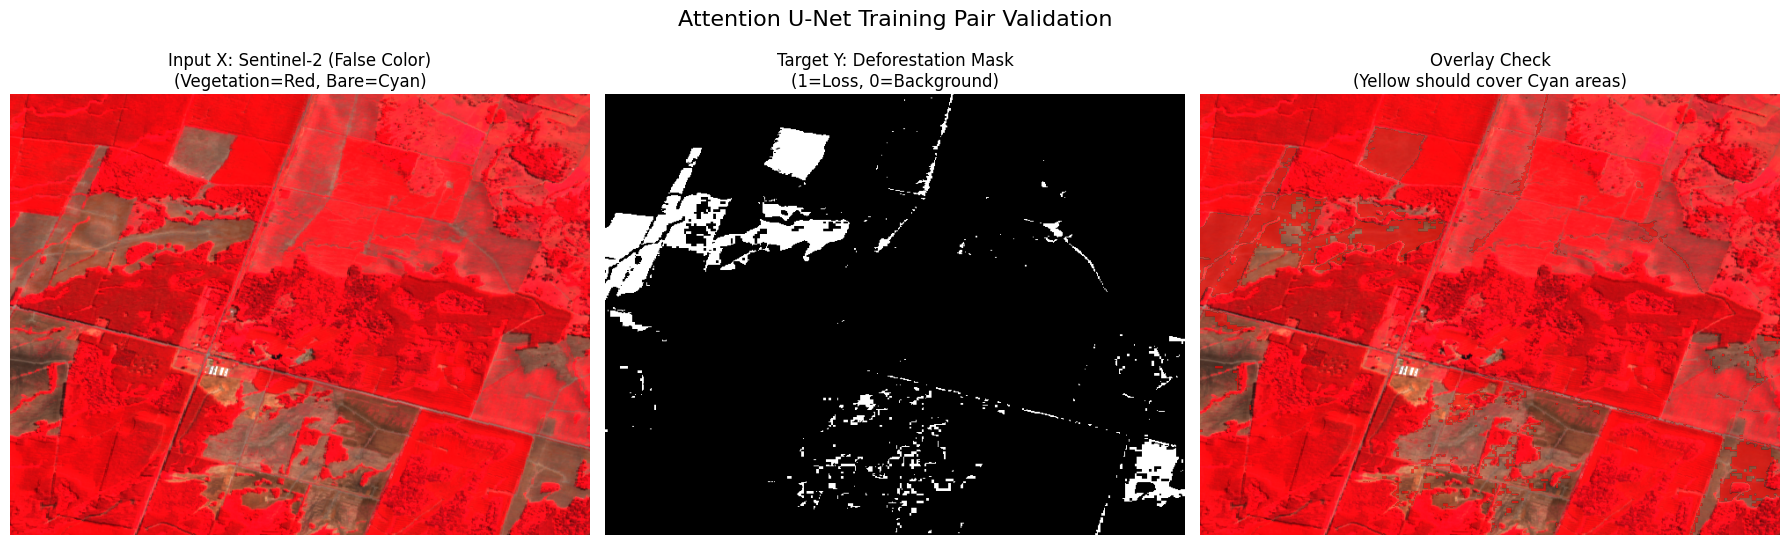

In [5]:
# --- PATHS (Pointing to the ML Chips generated in generate_ml_chip.py) ---
# Input X (Sentinel-2)
sentinel_chip_path = sentinel_path
# Target Y (Your Final Cleaned Label)
label_chip_path = mask_output_path

def validate_ml_pair(s2_path, label_path):
    if not os.path.exists(s2_path) or not os.path.exists(label_path):
        print("Files not found! Make sure you ran 'generate_ml_chip.py' successfully.")
        return

    # 1. Read Sentinel-2 (False Color for Visibility)
    with rasterio.open(s2_path) as src:
        # Bands: 1=Red, 2=Green, 3=Blue, 4=NIR (Based on our download script)
        nir = src.read(4)
        red = src.read(1)
        green = src.read(2)
        
        # Normalize to 0-1
        def norm(band): 
            return np.clip(band / 3000.0, 0, 1) # Sentinel scale
            
        # Create False Color (NIR, Red, Green) -> Vegetation=Red, Bare=Grey/Cyan
        false_color = np.dstack((norm(nir), norm(red), norm(green)))

    # 2. Read Label
    with rasterio.open(label_path) as src:
        label = src.read(1)

    # 3. Plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # A. Sentinel Input
    ax[0].imshow(false_color)
    ax[0].set_title("Input X: Sentinel-2 (False Color)\n(Vegetation=Red, Bare=Cyan)", fontsize=12)
    ax[0].axis('off')

    # B. Label (Ground Truth)
    ax[1].imshow(label, cmap='gray')
    ax[1].set_title("Target Y: Deforestation Mask\n(1=Loss, 0=Background)", fontsize=12)
    ax[1].axis('off')

    # C. Overlay (Quality Check)
    ax[2].imshow(false_color)
    # Overlay mask in Yellow (Gold)
    ax[2].imshow(np.ma.masked_where(label == 0, label), cmap='autumn', alpha=0.6)
    ax[2].set_title("Overlay Check\n(Yellow should cover Cyan areas)", fontsize=12)
    ax[2].axis('off')

    plt.suptitle("Attention U-Net Training Pair Validation", fontsize=16)
    plt.tight_layout()
    plt.show()

# Run
validate_ml_pair(sentinel_chip_path, label_chip_path)

## Using sentinel 2016 as reference for forest vs 2000 hansen tree coverage

In [19]:
import os
import rasterio
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from rasterio.vrt import WarpedVRT
from rasterio.enums import Resampling

# --- CONFIGURATION ---
# Path to your RAW Sentinel-2 Multi-band image
sentinel_raw_path = "/home/dhuencho/dev_py/0001_start_pytorch/src/UCL_AI4SD/CW2/data/chile_gfc_data/sentinel2_2016_robust_composite.tif"

# *** IMPORTANT: SET YOUR BAND INDICES HERE ***
# (Rasterio uses 1-based indexing. e.g., if Red is the 4th band, put 4)
RED_BAND_IDX = 3  
NIR_BAND_IDX = 4

# NDVI Threshold (0.5 to 0.7 is typical for dense forest)
NDVI_THRESHOLD = 0.6 

# Your existing settings
DENSITY_THRESHOLD = 0.005 
BLOCK_SIZE = 2048 
RECENCY_THRESHOLD_YEAR = 17
decimation_factor = 10

mask_output_path = os.path.join(output_dir, f"{granule}_filtered_S2_calculated_{str(DENSITY_THRESHOLD).replace('.','')}.tif")

# ==========================================
# PART 1: PREPARE HOTSPOT MASK (Low Res)
# ==========================================
print("Loading data with smart decimation...")

# We use Loss Year as the reference for shape/projection
with rasterio.open(lossyear_path) as src_ref:
    ref_profile = src_ref.profile
    ref_h, ref_w = src_ref.height, src_ref.width
    ref_transform = src_ref.transform
    ref_crs = src_ref.crs
    
    # Calculate new small shape
    new_height = ref_h // decimation_factor
    new_width = ref_w // decimation_factor

    # 1. Read Loss (Small)
    lossyear_small = src_ref.read(
        1,
        out_shape=(new_height, new_width),
        resampling=Resampling.nearest
    )

# 2. Read Sentinel Red/NIR and Calculate NDVI (Small)
# We use WarpedVRT to align Sentinel to GFW grid automatically
print("   ...Warping Sentinel-2 & Calculating NDVI preview...")
with rasterio.open(sentinel_raw_path) as src_s2:
    with WarpedVRT(src_s2, crs=ref_crs, transform=ref_transform, 
                   width=ref_w, height=ref_h, resampling=Resampling.bilinear) as vrt_s2:
        
        # Read Red and NIR bands (downsampled)
        red_small = vrt_s2.read(
            RED_BAND_IDX,
            out_shape=(new_height, new_width),
            resampling=Resampling.bilinear
        ).astype(np.float32)

        nir_small = vrt_s2.read(
            NIR_BAND_IDX,
            out_shape=(new_height, new_width),
            resampling=Resampling.bilinear
        ).astype(np.float32)

        # Calculate NDVI on the small arrays
        # Ignore division by zero errors
        with np.errstate(divide='ignore', invalid='ignore'):
            ndvi_small = (nir_small - red_small) / (nir_small + red_small)
            ndvi_small = np.nan_to_num(ndvi_small, nan=-1.0) # cleanup NaNs

with rasterio.open(datamask_path) as src:
    datamask_small = src.read(
        1,
        out_shape=(new_height, new_width),
        resampling=Resampling.nearest
    )

print(f"Data loaded. NDVI Shape: {ndvi_small.shape}")

# 3. Create Masks logic (Updated with NDVI)
land_mask_small = (datamask_small == 1)
forest_baseline_mask_small = (ndvi_small > NDVI_THRESHOLD) # <--- NEW CONDITION

# 4. Create Cumulative Loss Layer
cumulative_loss_small = (
    (lossyear_small >= RECENCY_THRESHOLD_YEAR) & 
    forest_baseline_mask_small & 
    land_mask_small
).astype(np.float32)

# 5. Apply Gaussian Density
sigma_adjusted = 5 
loss_density_heatmap = gaussian_filter(cumulative_loss_small, sigma=sigma_adjusted)

# 6. Prepare Final Hotspot Mask
print("1. Preparing Hotspot Mask...")
hotspot_mask_small = (loss_density_heatmap > DENSITY_THRESHOLD).astype(np.uint8)

# Resize to full resolution
hotspot_mask_full = cv2.resize(
    hotspot_mask_small, 
    (ref_w, ref_h), 
    interpolation=cv2.INTER_NEAREST
)
print(f"   Hotspot mask ready: {hotspot_mask_full.shape}")

# ==========================================
# PART 2: BLOCK PROCESSING (Full Res)
# ==========================================

# Configure Output
profile = ref_profile.copy()
profile.update({
    'dtype': rasterio.uint8, 'count': 1, 'nodata': 0,
    'driver': 'GTiff', 'compress': 'lzw', 'tiled': True,
    'blockxsize': 256, 'blockysize': 256
})

print("2. Starting Block Processing with On-the-Fly NDVI...")

with rasterio.open(lossyear_path) as src_ly, \
     rasterio.open(datamask_path) as src_dm, \
     rasterio.open(sentinel_raw_path) as src_s2, \
     rasterio.open(mask_output_path, 'w', **profile) as dst:
    
    # Virtual Wrapper for Sentinel
    with WarpedVRT(src_s2, crs=ref_crs, transform=ref_transform, 
                   width=ref_w, height=ref_h, resampling=Resampling.bilinear) as src_s2_aligned:

        windows = [window for ji, window in dst.block_windows(1)]
        
        for window in tqdm(windows):
            # A. Read GFW Data
            loss_chunk = src_ly.read(1, window=window)
            dm_chunk = src_dm.read(1, window=window)
            
            # B. Read Sentinel Bands & Calc NDVI for this chunk
            red_chunk = src_s2_aligned.read(RED_BAND_IDX, window=window).astype(np.float32)
            nir_chunk = src_s2_aligned.read(NIR_BAND_IDX, window=window).astype(np.float32)
            
            with np.errstate(divide='ignore', invalid='ignore'):
                ndvi_chunk = (nir_chunk - red_chunk) / (nir_chunk + red_chunk)
                # We don't strictly need nan_to_num here if we just do a comparison
                # But it's safer for the threshold check:
                # Any NaN will result in False for (NaN > Threshold), which is what we want.

            # C. Hotspot chunk slice
            r_start = window.row_off
            r_end = r_start + window.height
            c_start = window.col_off
            c_end = c_start + window.width
            hotspot_chunk = hotspot_mask_full[r_start:r_end, c_start:c_end]
            
            # D. Compute Logic
            mask_chunk = (
                (loss_chunk >= RECENCY_THRESHOLD_YEAR) & 
                (ndvi_chunk > NDVI_THRESHOLD) &  # <--- Filter by calculated NDVI
                (dm_chunk == 1) & 
                (hotspot_chunk == 1)
            ).astype(np.uint8)
            
            dst.write(mask_chunk, 1, window=window)

print(f"Success! Mask saved to: {mask_output_path}")

Loading data with smart decimation...
   ...Warping Sentinel-2 & Calculating NDVI preview...
Data loaded. NDVI Shape: (4000, 4000)
1. Preparing Hotspot Mask...
   Hotspot mask ready: (40000, 40000)
2. Starting Block Processing with On-the-Fly NDVI...


100%|██████████| 24649/24649 [00:20<00:00, 1220.60it/s]

Success! Mask saved to: ./data/chile_gfc_data/40S_080W_filtered_S2_calculated_0005.tif
